In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline #preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from imblearn.pipeline import Pipeline as pipe #model processed data

In [2]:
pkl_path = 'cone_burnout_data.pkl'

In [3]:
df = pd.read_pickle(pkl_path)

In [4]:
df.head()

,employee_obj_id,clicks_count,patients_accessed_count,after_hours_count,value,indicator
0,119132,45109.0,751.0,446.0,GNA-GUILFORD NEUROLOGIC MAIN,0
1,119581,15991.0,443.0,375.0,LB-62930 VINCENT W RCK MADIS,0
2,119624,8401.0,207.0,106.0,WHG-PHYSICAL THERAPY,0
3,119634,90130.0,638.0,414.0,AAPC-ALAMANCE REG PAIN CLINIC,0
4,119728,24471.0,516.0,403.0,UMFMD-EVA SHAW MD,0


In [5]:
y_check = df['indicator']
y_check=y_check.astype('int')
print(y_check.value_counts())

0    726
1     61
Name: indicator, dtype: int64


In [6]:
train_df = df.sample(frac=0.7, random_state=1019)
test_df = df.drop(train_df.index)

In [7]:
true_y = train_df['indicator']
test_y = test_df['indicator']

In [8]:
true_y=true_y.astype('int')
test_y=test_y.astype('int')

In [9]:
train_X = train_df.drop(['employee_obj_id','indicator'],axis=1)
test_X = test_df.drop(['employee_obj_id','indicator'],axis=1)

In [10]:
train_X = train_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT', 
                          'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 
test_X = test_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT',
                        'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 

In [11]:
train_X.head()

,CLICKS,NUM_PATIENTS,AFTER_HOURS,DEPT
224,NaN,NaN,NaN,NaN
166,16302.0,781.0,516.0,DST-DR W SPENCER TILLEY PRACT
53,13215.0,682.0,545.0,BH-PHYSICIAN SERVICES
706,NaN,NaN,NaN,NaN
148,11554.0,77.0,66.0,MHC - DIV 4000 - IP REHAB


In [12]:
test_y.value_counts()

0    218
1     18
Name: indicator, dtype: int64

In [13]:
def transform_pipeline(categorical_features,numeric_features):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])    
    
    ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])  
    
    return ct  

In [14]:
numerical_features = ['NUM_PATIENTS','CLICKS','AFTER_HOURS']
categorical_features = ['DEPT']

In [16]:
ct = transform_pipeline(categorical_features,numerical_features)

In [17]:
#apply the transform 
X_train_trans = ct.fit_transform(train_X)
X_test_trans = ct.transform(test_X)

In [18]:
def ml_pipeline():
    ss_step = ('ss', StandardScaler(with_mean=False))

    rfc_step = ('rfc',RandomForestClassifier())
    
    pipeline_steps = [ss_step, rfc_step]
    
    ml_pipe = pipe(pipeline_steps)
    
    return ml_pipe

In [19]:
ml_pipe = ml_pipeline()

In [20]:
#fit to train
ml_pipe.fit(X_train_trans,true_y)

Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('rfc', RandomForestClassifier())])

In [21]:
#predict on test
y_pred = ml_pipe.predict(X_test_trans)
y_prob = ml_pipe.predict_proba(X_test_trans)[:,1]

In [22]:
#metrics

In [23]:
scores = cross_val_score(ml_pipe, X_train_trans, true_y, cv=5)

In [24]:
scores

array([0.91891892, 0.92727273, 0.92727273, 0.91818182, 0.91818182])

In [25]:
cr = classification_report(test_y,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       218
           1       0.00      0.00      0.00        18

    accuracy                           0.92       236
   macro avg       0.46      0.50      0.48       236
weighted avg       0.85      0.92      0.89       236



/Users/dadams/.pyenv/versions/3.7.7/envs/eba/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
cm = confusion_matrix(test_y,y_pred)
print(cm)

[[218   0]
 [ 18   0]]


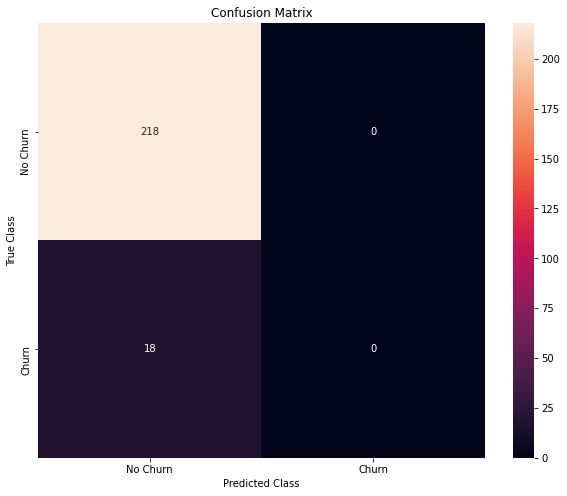

In [27]:
def plot_cm(cm):
    labels = ['No Churn','Churn']
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show

plot_cm(cm)

In [28]:
fpr, tpr, thresholds = roc_curve(test_y,y_prob)
roc_auc = auc(fpr,tpr)

In [29]:
def plot_roc(fpr, tpr, thresholds,roc_auc):
    plt.figure(figsize=(15,8))
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

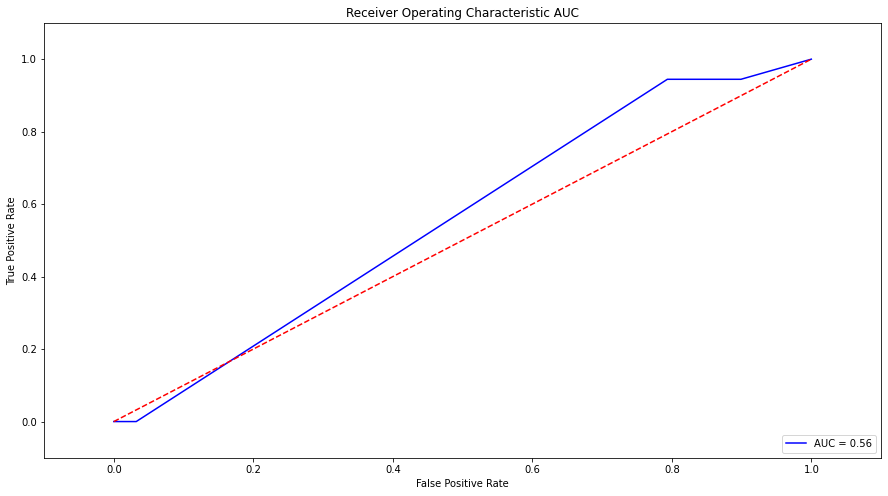

In [30]:
plot_roc(fpr, tpr, thresholds,roc_auc)

In [43]:
#ooh a different way to make a pipeline...
num_transformer = Pipeline(steps=[
                  ('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['NUM_PATIENTS','CLICKS','AFTER_HOURS']
categorical_features = ['DEPT']

ct = ColumnTransformer(transformers=[
            ('numerical_preprocessing', num_transformer, numerical_features),
       ('categorical_preprocessing', cat_transformer, categorical_features)],
        remainder='passthrough',
        verbose=True)

# Create the classifier
classifier = RandomForestClassifier()

# Create the overall model as a single pipeline
pipeline = Pipeline([("transform_inputs", ct), ("classifier", classifier)])

pipeline.fit(train_X, true_y)

onehot_columns = pipeline.named_steps['transform_inputs'].named_transformers_['categorical_preprocessing'].named_steps['onehot'].get_feature_names(input_features=categorical_features)


#you can get the values transformed with your pipeline
X_values = ct.fit_transform(train_X)

[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s


In [38]:
cols = numerical_features + list(onehot_columns)

In [39]:
cols

['NUM_PATIENTS',
 'CLICKS',
 'AFTER_HOURS',
 'DEPT_AAA-ALLERGY AND ASTHMA GSO',
 'DEPT_AAA-ALLERGY AND ASTHMA HIGH PT',
 'DEPT_AAPC-ALAMANCE REG PAIN CLINIC',
 'DEPT_AEC-EP REHAB 1ST FLOOR',
 'DEPT_APH-PHYSICAL THERAPY',
 'DEPT_APS-APC-CRISSMAN FAM PRAC',
 'DEPT_APS-BURLINGTON FAMILY',
 'DEPT_ARMC-ADLT BEHAV MED-LOWER',
 'DEPT_ARMC-AMBULATORY SURGERY',
 'DEPT_ARMC-CLINIC RESEARCH',
 'DEPT_ARMC-CLINICAL LABORATORY',
 'DEPT_ARMC-EMERGENCY ROOM',
 'DEPT_ARMC-GENSURGERY-2ND LEVEL',
 'DEPT_ARMC-ICU CCU-2ND LEVEL',
 'DEPT_ARMC-LABOR AND DELIVERY',
 'DEPT_ARMC-MEBANE SURGERY CNTR',
 'DEPT_ARMC-MOTHER-BABY 3RD LEVL',
 'DEPT_ARMC-NEWBORN NRSY 3RD LVL',
 'DEPT_ARMC-ORTHO REHAB 1ST LEVL',
 'DEPT_ARMC-PHARMACY',
 'DEPT_ARMC-RADIOLOGY DIAGNOSTIC',
 'DEPT_ARMC-URGENT CR MEBANE ASC',
 'DEPT_AVS-ALAMANCE VEIN VASC SURGERY',
 'DEPT_BH ASSESSMENT SERVICES',
 'DEPT_BH-IP ADULT SERVICES',
 'DEPT_BH-PHYSICIAN SERVICES',
 'DEPT_CHMG-HIM',
 'DEPT_CVD-CV BURLINGTON',
 'DEPT_CVD-CV NORTHLINE DIVISION',
 'DEPT_

In [40]:
df_from_array_pipeline = pd.DataFrame(X_values.toarray(), columns = cols)

In [41]:
feature_importance = pd.Series(data= pipeline.named_steps['classifier'].feature_importances_, index = np.array(cols))

In [42]:
feature_importance

NUM_PATIENTS                             0.113796
CLICKS                                   0.121665
AFTER_HOURS                              0.200033
DEPT_AAA-ALLERGY AND ASTHMA GSO          0.000197
DEPT_AAA-ALLERGY AND ASTHMA HIGH PT      0.001164
DEPT_AAPC-ALAMANCE REG PAIN CLINIC       0.000678
DEPT_AEC-EP REHAB 1ST FLOOR              0.000677
DEPT_APH-PHYSICAL THERAPY                0.000062
DEPT_APS-APC-CRISSMAN FAM PRAC           0.000214
DEPT_APS-BURLINGTON FAMILY               0.000124
DEPT_ARMC-ADLT BEHAV MED-LOWER           0.000032
DEPT_ARMC-AMBULATORY SURGERY             0.000283
DEPT_ARMC-CLINIC RESEARCH                0.000046
DEPT_ARMC-CLINICAL LABORATORY            0.000027
DEPT_ARMC-EMERGENCY ROOM                 0.000127
DEPT_ARMC-GENSURGERY-2ND LEVEL           0.098065
DEPT_ARMC-ICU CCU-2ND LEVEL              0.001646
DEPT_ARMC-LABOR AND DELIVERY             0.000188
DEPT_ARMC-MEBANE SURGERY CNTR            0.000246
DEPT_ARMC-MOTHER-BABY 3RD LEVL           0.000125
